# Read key from QrCode
The camera read the qr code and use that as encription key

In [1]:
# !pip install qrcode

## Name of the room

In [2]:
# some handy functions to use along widgets
from IPython.display import display, Markdown, clear_output
# widget packages
import ipywidgets as widgets

In [3]:
text = widgets.Text(
       value='Room1',
       description='Room', )

In [4]:
box = widgets.VBox([text])
box

## Simulate acquisition of QR Code

In [5]:
from pymongo import MongoClient

In [6]:
db_name = 'whereismy'
ip = "mongo"
port = 27017
user = "root"
password = "example"

In [7]:
mongo_client = MongoClient(f'{ip}:{port}',
                      username=user,
                      password=password,
                      authSource='admin',
                      )
print(mongo_client)
print(mongo_client.list_database_names())
db = mongo_client.get_database(db_name)
print(db)
print(db.list_collection_names())
cameras_collection = db.cameras
print(cameras_collection)
for x in cameras_collection.find():
    print(x)

MongoClient(host=['mongo:27017'], document_class=dict, tz_aware=False, connect=True, authsource='admin')
['admin', 'config', 'local', 'whereismy']
Database(MongoClient(host=['mongo:27017'], document_class=dict, tz_aware=False, connect=True, authsource='admin'), 'whereismy')
['cameras']
Collection(Database(MongoClient(host=['mongo:27017'], document_class=dict, tz_aware=False, connect=True, authsource='admin'), 'whereismy'), 'cameras')
{'_id': ObjectId('607d3e8489294b2c8efb525a'), 'name': 'Room1', 'key': 'uPROkCGU'}


In [8]:
cam = cameras_collection.find_one({"name": text.value})
key = cam['key']
print(key)

uPROkCGU


In [9]:
import qrcode
from IPython.display import display

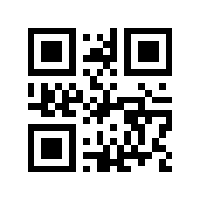

In [10]:
image_path = '/tmp/qr.jpg'
img = qrcode.make(key)
img.save(image_path, 'JPEG')

# Scale and show
img.thumbnail((200, 200))
display(img)

## Read QR Code

In [11]:
# !apt install libopencv-dev python3-opencv

In [12]:
import cv2

In [13]:
detector = cv2.QRCodeDetector()
cv2_img = cv2.imread('/tmp/qr.jpg')

In [14]:
data, bbox, straight_qrcode = detector.detectAndDecode(cv2_img)
print(data)

uPROkCGU


In [15]:
# !pip install pycrypto

In [16]:
from Crypto.Cipher import DES
crypt = DES.new(data)

In [17]:
def padding(data):
        bs = DES.block_size
        padding = bs - len(data) % bs
        padding_text = chr(padding) * padding
        return data + padding_text

In [19]:
msg = "test"
msg = padding(msg)
print("msg:", msg)

cripted = crypt.encrypt(msg)
print("cripted:", cripted)

decripted = crypt.decrypt(cripted)
decripted_string = decripted.decode("utf-8")
print("decripted:", decripted_string)

msg: test
cripted: b'e\xae_n\xb1\x12w:'
decripted: test


# AI Code

In [20]:
# ! pip install torch

In [21]:
# !pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt 

In [22]:
import torch
import os

In [23]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Focus                     [3, 32, 3]                    
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  1    156928  models.common.C3                        [128, 128, 3]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  1    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv                   

Adding autoShape... 


In [24]:
imgs = ['./teddy_bear.jpg', './phone.jpg']
results = model(imgs)

# Results
results.print() 

image 1/2: 768x1024 1 bed, 1 teddy bear
image 2/2: 533x800 2 cell phones
Speed: 112.7ms pre-process, 3410.6ms inference, 7.7ms NMS per image at shape (2, 3, 480, 640)


Saving results/teddy_bear.jpg, results/phone.jpg, done.


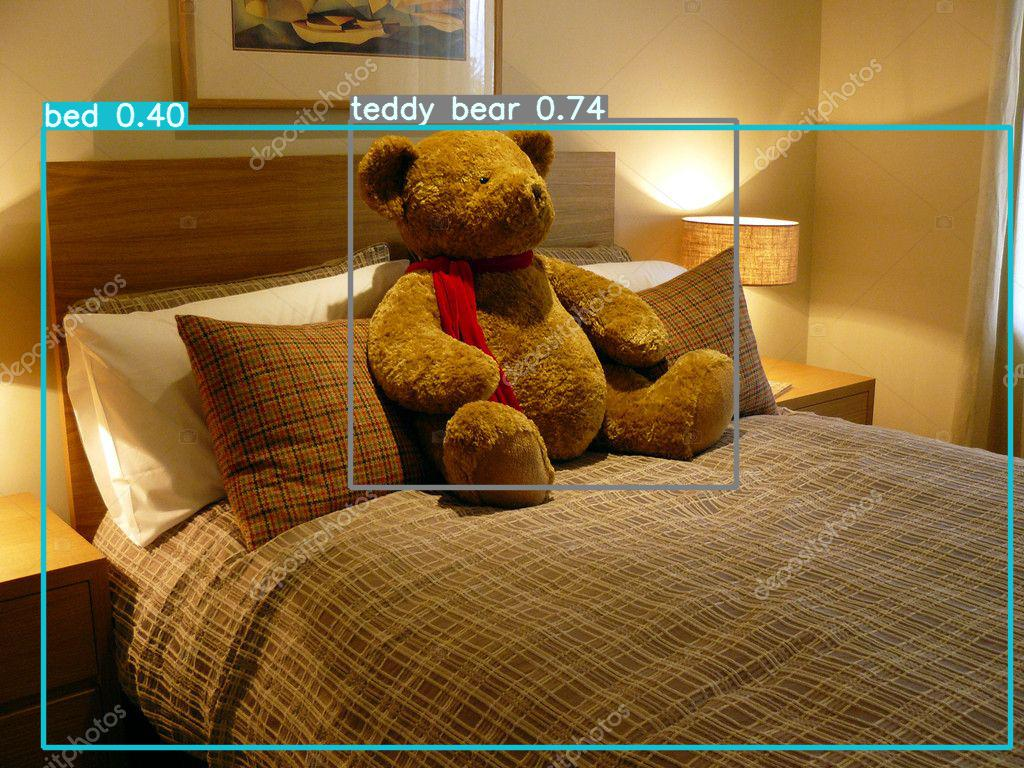

In [25]:
from IPython.display import Image
results.save()
Image('results/teddy_bear.jpg')

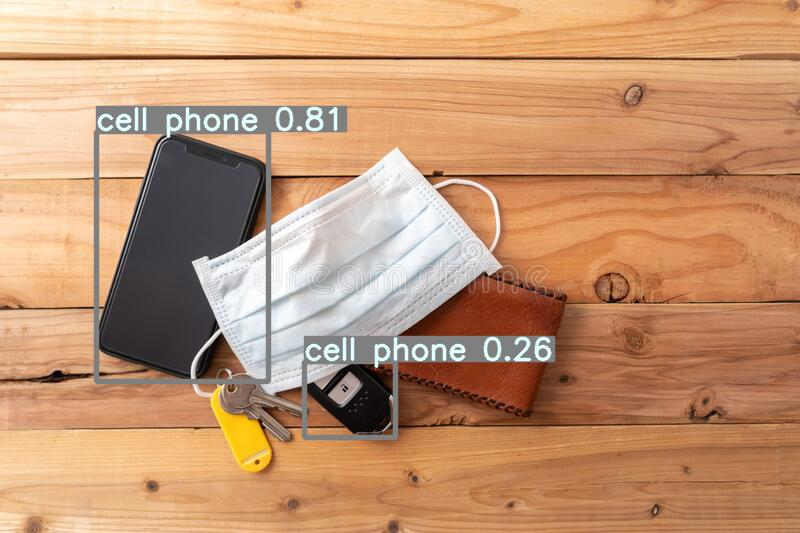

In [26]:
Image('results/phone.jpg')

In [27]:
names = model.module.names if hasattr(model, 'module') else model.names
# print(names)

for im_res in results.xyxy[1]:
    class_id = int(im_res[5].item())
    confidence = im_res[4].item()
    print('class:', names[class_id], 'confidence:', confidence)

class: cell phone confidence: 0.8060577511787415
class: cell phone confidence: 0.2608952224254608


In [28]:
threshold = 0.7 
def whereismy(text_class):
    imgs = ['./phone.jpg']
    results = model(imgs)
    for res in results.xyxy[0]:
        confidence = res[4].item()
        if confidence > threshold:
            class_id = int(res[5].item())
            class_name = names[class_id]
            if class_name == text_class:
                return True
        
    return False

# Listen MQTT and iamge scan
Read mqtt and decript, after call the async function that eventually publish

In [29]:
# !pip install paho-mqtt

In [30]:
import paho.mqtt.client as mqtt 
import time

In [31]:
ip="mqtt-broker"
port=8883
keepalive = 60

In [32]:
client = mqtt.Client("SmartHomeReciver")
client.connect(ip, port, keepalive)

0

In [33]:
def on_message(client, userdata, message):
    decoded_mex = str(message.payload.decode("utf-8"))
    print("received message: " ,decoded_mex)
    if whereismy(decoded_mex):
        msg = "there"
    else:
        msg = "not there"
    msg = padding(msg)
    msg = crypt.encrypt(msg)
    client.publish("/rooms/room1", msg)
# def on_disconnect(client, userdata, rc):
#     print("client disconnected ok")
    
client.loop_start()

client.subscribe("/whereismy")
client.on_message=on_message 

#client.on_disconnect = on_disconnect

In [34]:
client.publish("/whereismy", "test")

received message:  test
received message:  cell phone
received message:  teddy bear


In [ ]:
# client.loop_stop()